# L-RVGA

The Limited-memory Recursive Variational Gaussian Approximation equations are given by

$$
\begin{aligned}
    q^*_t(\theta) &= \arg\min_{\mu^*, P^*}
        \text{KL}\left(  \mathcal{N}(\theta \vert \mu^*, P^*)  || \mathcal{N}(\theta \vert \mu_{t-1}, P_{t-1}^{-1}) p(y_t \vert\theta) \right)\\
    q_t(\theta) &= \arg\min_{\mu, W, \Psi}
         \text{KL}\left( \mathcal{N}(\theta \vert \left(WW^T + \Psi\right)^{-1} || \mathcal{N}(\theta \vert \mu^*, P^*)   \right)
\end{aligned}
$$

## R-VGA for a linear model

We consider the case for a linear model of the form $y_t = x_t^T\theta + \epsilon_t$, where $\epsilon_t\sim\mathcal{N}(0, \sigma_\epsilon^2)$. If we set $\sigma_\epsilon^2 = 1$, the R-VGA equations are given by

$$
\begin{aligned}
    \mu_t &= \mu_{t-1} + P_t x_t (y_t - \mu_{t-1}x_t)\\
    P_t &= P_{t-1} - x_tx_t^T
\end{aligned}
$$

In [1]:
import jax
import chex
import numpy as np
import jax.numpy  as jnp
import matplotlib.pyplot as plt
from functools import partial
from jaxtyping import Array, Float, Int

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(314)
key_basis, key_x, key_y = jax.random.split(key, 3)

In [4]:
@partial(jax.vmap, in_axes=(0, None, None))
def rmse(state, X, y):
    yhat = jnp.einsum("m,nm->n", state.mu, X)
    loss = jnp.power(y - yhat, 2).mean()
    return loss


@chex.dataclass
class LMState:
    mu: Float[Array, "obs_dim"]
    Pinv: Float[Array, "obs_dim obs_dim"]
    

def lrstep(_, state, obs):
    x, y = obs
    mu, Pinv = state
    P = jnp.linalg.inv(Pinv)
    mu = mu + P @ x * (y - mu @ x)
    Pinv = Pinv + x @ x.T
    
    return mu, Pinv
    
    
def rvga_update(state:LMState, obs, n_its=1):
    """
    Perform a Recursive Variational Gaussian Approximation
    step for a linear model of the form y=w^T*x + eps
    """
    mu = state.mu
    Pinv = state.Pinv
    
    step_partial = partial(lrstep, obs=obs)
    state = (mu, Pinv)
    mu, Pinv = jax.lax.fori_loop(0, n_its, step_partial, state)
    
    state_new = LMState(mu=mu, Pinv=Pinv)
    
    return state_new, state_new

In [6]:
def plot_history_eval(hist, train, test, ax, skip=0):
    X, y = train
    X_test, y_test = test
    
    n_train = len(y)
    range_test = jnp.arange(skip + 1, n_train + 1)
    
    rmse_vals_test = rmse(hist, X_test, y_test)
    rmse_vals_train = rmse(hist, X, y)
    
    ax.plot(range_test, rmse_vals_train[skip:], label="train")
    ax.plot(range_test, rmse_vals_test[skip:], label="test")
    ax.legend()
    ax.grid(alpha=0.5)
    ax.set_title("RMSE")    
    return True


def plot_hist_param(hist, params_true, train, ax, skip=0):
    cmap = plt.cm.tab10
    _, y = train
    n_train = len(y)
    n_params = len(params_true)
    params_hist = hist["mu"][skip:].T
    
    range_test = jnp.arange(skip + 1, n_train + 1)
    colors = cmap(np.linspace(0, 1, n_params))
    
    for i, (color, p_true, p_hist) in enumerate(zip(colors, params_true, params_hist)):
        ax.plot(range_test, p_hist, label=fr"$\theta({i})$-rvga", color=color)
        ax.axhline(y=p_true, linestyle="--", label=fr"$\theta$({i})-true", color=color)
    ax.legend()
    ax.set_title("Param estimation")
    ax.grid(alpha=0.5)
    

def plot_test(hist, params_true, train, test, ax, skip=0):
    params_hist = hist["mu"][skip:].T
    X, y = train
    X_test, y_test = test
    
    plot_history_eval(hist, train, test, ax[0], skip)
    plot_hist_param(hist, params_true, train, ax[1], skip)

### Training / test dataset

In [380]:
n_train = 250
n_test = 50
n_total = n_train + n_test
xvals = jax.random.uniform(key_x, (n_total, 1), minval=-2, maxval=3)
X = jnp.c_[xvals, xvals ** 2]

theta = jnp.array([2.0, -1.0])
eps_vals = jax.random.normal(key_y, (n_total,))
y = jnp.einsum("m,nm->n", theta, X) + eps_vals


X_test = X[-n_test:]
y_test = y[-n_test:]

X = X[:-n_test]
y = y[:-n_test]

xvals_test = xvals[-n_test:].ravel()
xvals = xvals[:-n_test]

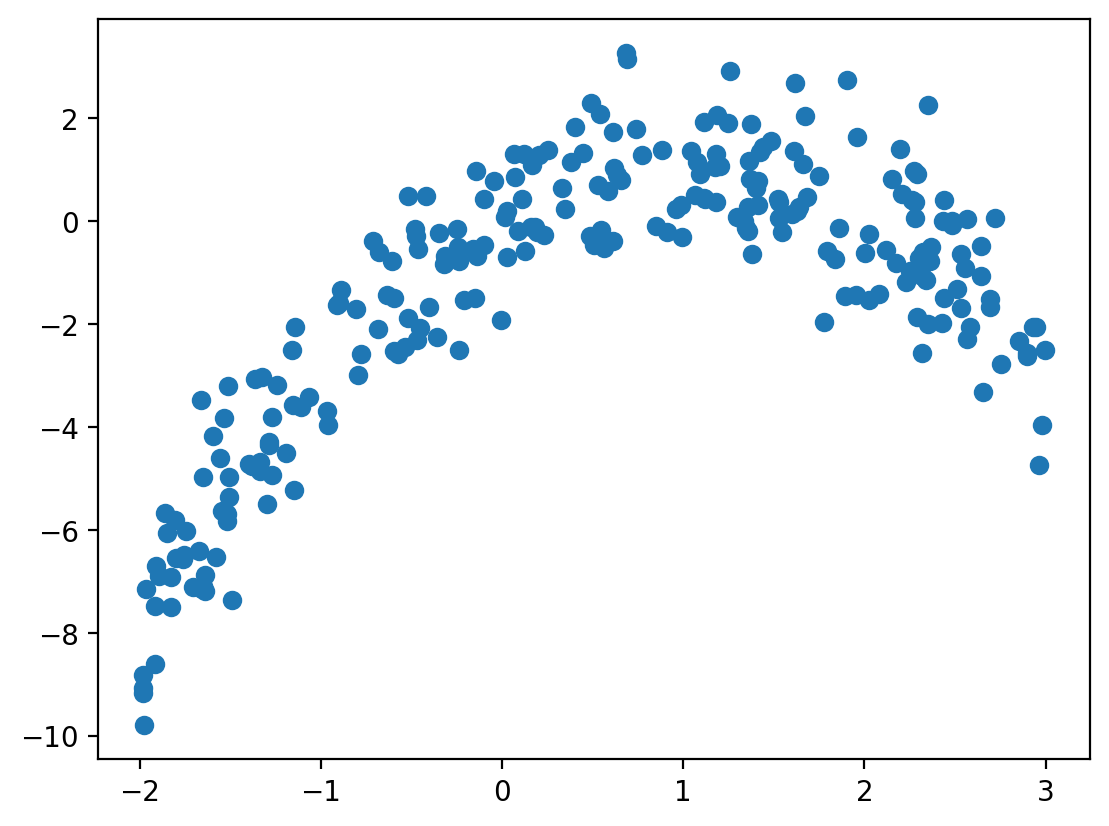

In [381]:
plt.scatter(xvals, y)

### Running R-VGA (unsorted)

In [404]:
train = (X, y)
test = (X_test, y_test)

Pinv0 = jnp.eye(2) * 10
mu0 = jnp.array([0.0, 0.0])
state0 = LMState(mu=mu0, Pinv=Pinv0)

D = (X, y[:, None])

state, hist = jax.lax.scan(rvga_update, state0, D)

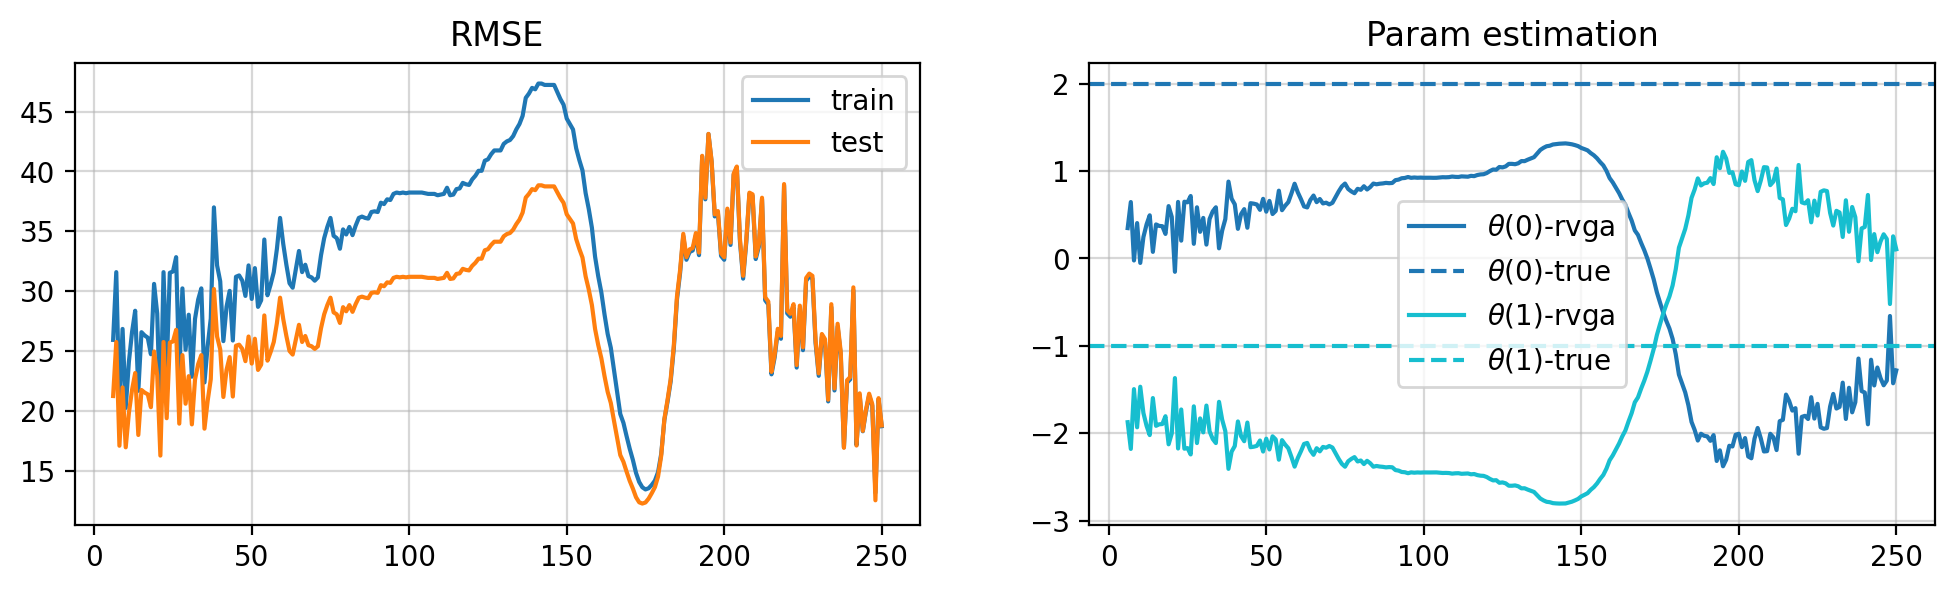

In [405]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot_test(hist, theta, train, test, ax, skip=5)

### Running R-VGA (sorted)

In [406]:
ix_sort = jnp.argsort(xvals.ravel())
xvals = xvals[ix_sort]
X = X[ix_sort]
y = y[ix_sort]

train = (X, y)

### Single iteration

In [407]:
Pinv0 = jnp.eye(2) * 10
mu0 = jnp.array([0.0, 0.0])
state0 = LMState(mu=mu0, Pinv=Pinv0)

D = (X, y[:, None])

partial_rvga = partial(rvga_update, n_its=1)
state, hist = jax.lax.scan(partial_rvga, state0, D)

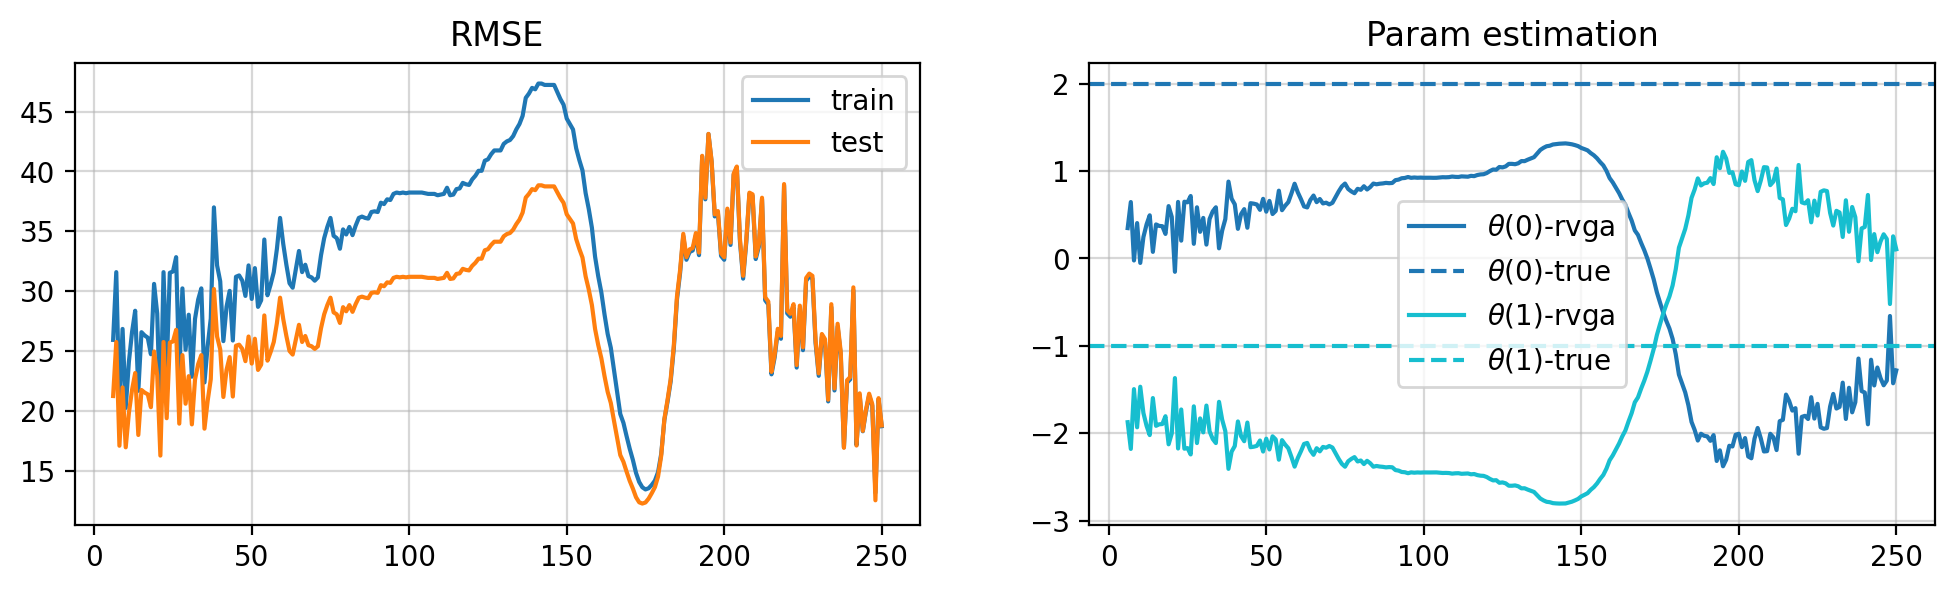

In [408]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot_test(hist, theta, train, test, ax, skip=5)

### Five iterations

In [316]:
partial_rvga = partial(rvga_update, n_its=5)
state, hist = jax.lax.scan(partial_rvga, state0, D)

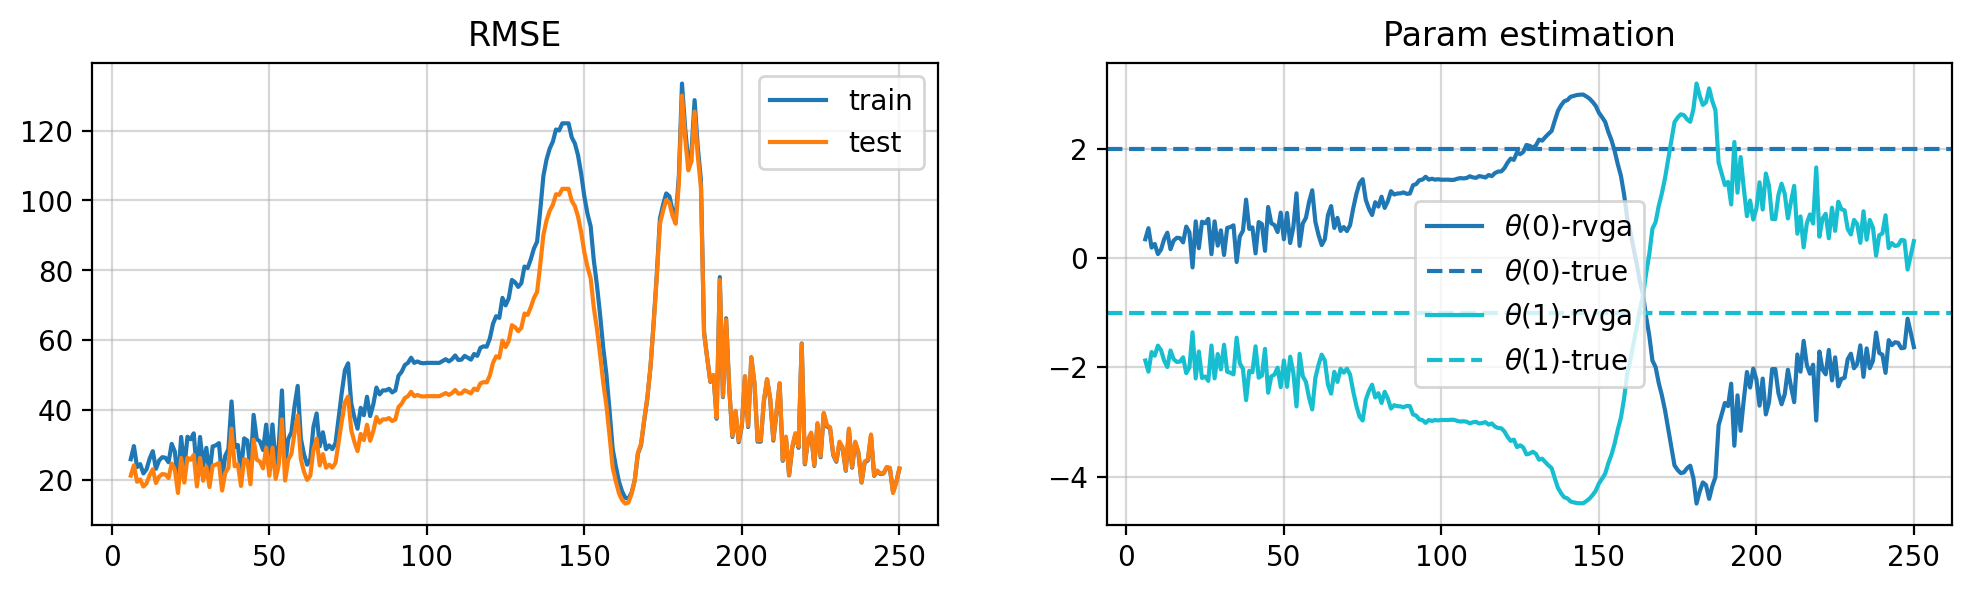

In [317]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot_test(hist, theta, train, test, ax, skip=5)

## Fourier features

In [409]:
def fourier_basis(domain, b_coef):
    n_obs = len(domain)
    # We take aj=1
    elements = jnp.einsum("...m,bm->...b", domain, b_coef)
    elements = 2 * jnp.pi * elements
    cos_elements = jnp.cos(elements)
    sin_elements = jnp.sin(elements)
    
    elements = jnp.stack([cos_elements, sin_elements], axis=-1)
    elements = elements.reshape(n_obs, -1)
    elements = jnp.append(elements, jnp.ones(n_obs)[:, None], axis=1)
    return elements

In [410]:
num_basis = 4
input_dim = 2
b = jax.random.normal(key_basis, (num_basis, input_dim)) * 0.1

In [411]:
Xf = fourier_basis(X, b)
Xf_test = fourier_basis(X_test, b)

train = (Xf, y)
test = (Xf_test, y_test)

In [412]:
_, n_dim = Xf.shape
Pinv0 = jnp.eye(n_dim) * 10.0
mu0 = jnp.zeros(n_dim)
state0 = LMState(mu=mu0, Pinv=Pinv0)

Df = (Xf, y)

partial_rvga = partial(rvga_update, n_its=2)
state, hist = jax.lax.scan(partial_rvga, state0, Df)

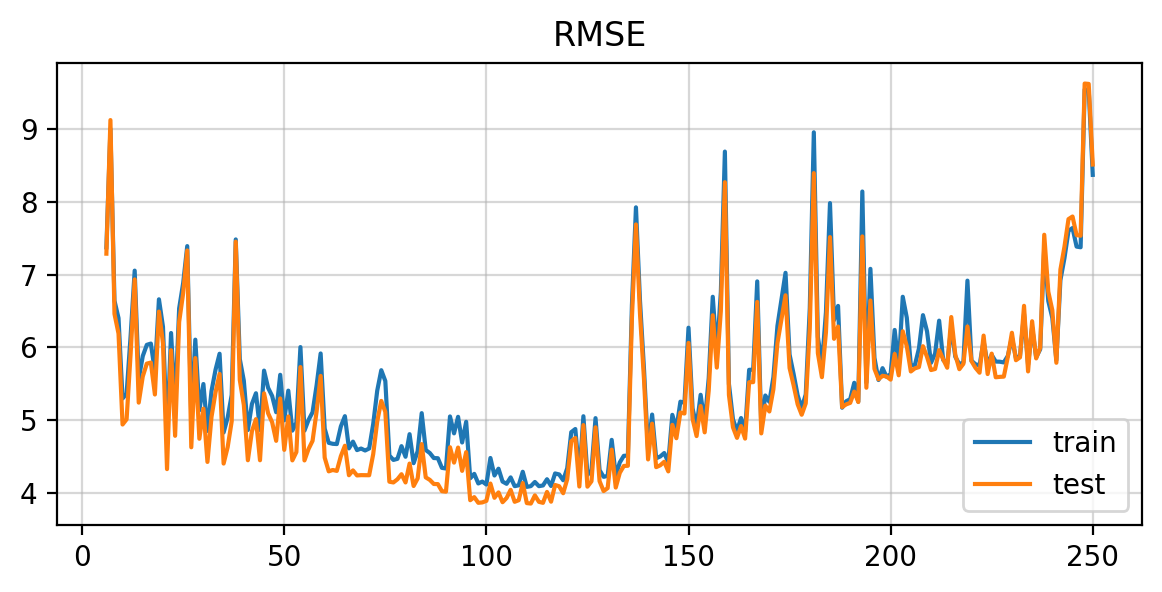

In [413]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_history_eval(hist, train, test, ax, skip=5);

## Animating results

In [414]:
from matplotlib.animation import FuncAnimation

In [ ]:
yhat = jnp.einsum("tm,nm->tn", hist.mu, Xf)
plt.scatter(xvals, yhat[-1])
plt.scatter(xvals, y)

CPU times: user 35.4 s, sys: 3.51 s, total: 38.9 s
Wall time: 30.3 s


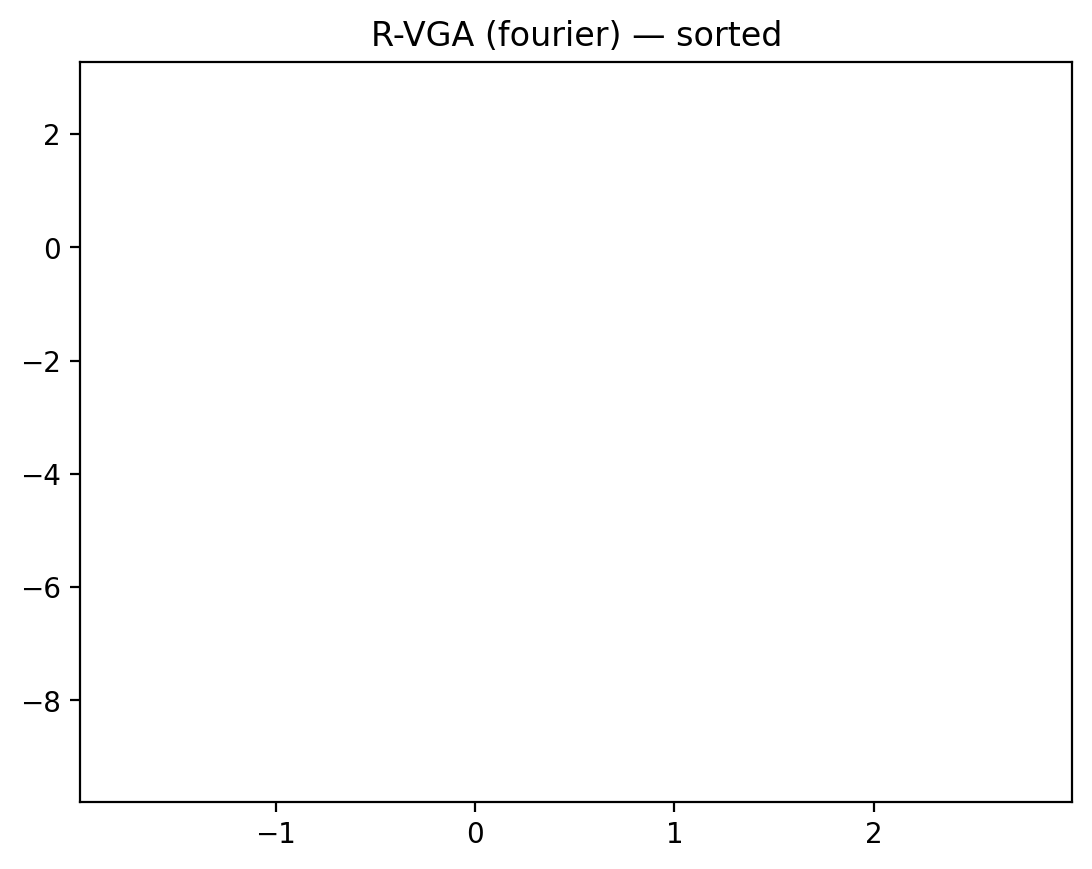

In [416]:
%%time
fig, ax = plt.subplots()

ix_sort = np.argsort(xvals.ravel())
def update(frame):
    ax.cla()
    ax.set_xlim(xvals.min(), xvals.max())
    ax.set_ylim(y.min(), y.max())

    xt = xvals[:frame]
    yt = y[:frame]

    ax.scatter(xt, yt, c="tab:blue")
    ax.scatter(xvals[:frame], yhat[frame][:frame], c="tab:orange")
    ax.set_title("R-VGA (fourier) — sorted")
    return ax

frames = np.arange(n_train)
ani = FuncAnimation(fig, update, frames=frames)


ani.save("rvga-fourier-sorted.mp4", dpi=100, bitrate=-1, fps=10)